In [89]:
!pip install opencv-python pillow imageio torch torchvision matplotlib scikit-image

Defaulting to user installation because normal site-packages is not writeable
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 88.0 MB/s eta 0:00:00
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 50.6 MB/s eta 0:00:00a 0:00:01


In [1]:
import cv2
import os
import glob
import time
from PIL import Image
import numpy as np
import PIL
import imageio
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from UtilityTest import DepthDataset
from UtilityTest import ToTensor

In [95]:
Location_video='./test_vid/video2.mp4'

In [6]:
#Extract the video from zipfile
# from zipfile import ZipFile
# zf = ZipFile('/test_vid.zip', 'r')
# zf.extractall('/')
# zf.close()

In [98]:
#converting video into frames
vidcap = cv2.VideoCapture(Location_video)
success,image = vidcap.read()
count = 0

if not os.path.exists('./test_vid/frames/'):
    os.mkdir('./test_vid/frames/')

while success:
    image = cv2.flip(image, 0)      # Only for video 2 as it was coming flipped
    cv2.imwrite("./test_vid/frames/frame%d.jpg" % count, image)     # save frame as JPEG file      
    success,image = vidcap.read()
    print('Read a new frame: ', success)
    count += 1

vidcap.release()

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

0 (1920, 1080)
1 (1920, 1080)
2 (1920, 1080)


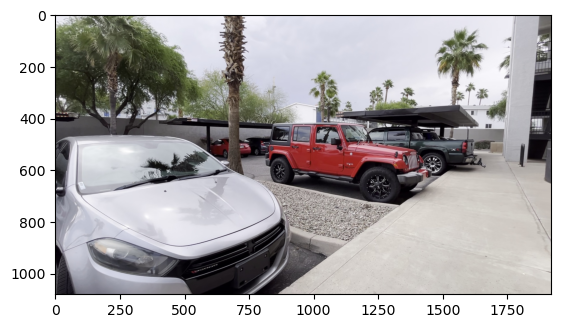

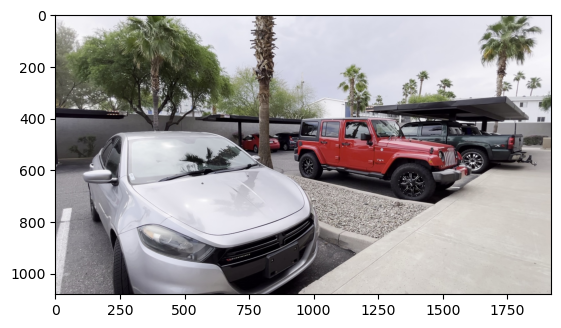

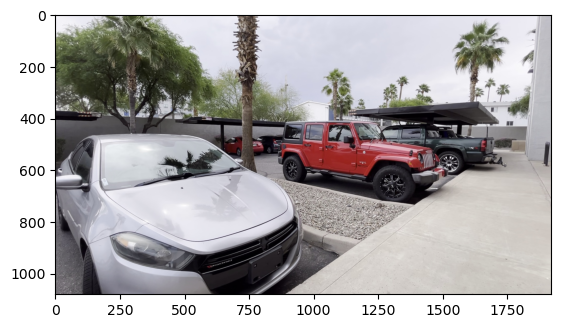

<Figure size 640x480 with 0 Axes>

In [99]:
#location of video frames
loc_img='./test_vid/frames/'

#ploting few sample frames
depth_dataset = DepthDataset(root_dir=loc_img)
fig = plt.figure()
len(depth_dataset)
for i in range(len(depth_dataset)):
    sample = depth_dataset[i]
    print(i, sample['image'].size)
    
    plt.imshow(sample['image'])
    plt.figure()
    
    if i == 2:
        plt.show()
        break

In [18]:
import torch
import torch.nn as nn
import torch.nn.utils as utils
import torchvision.utils as vutils    
import torchvision.models as models
from mobile_model import Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)
if device == 'cuda' and torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
#loading the the trained model
checkpoint = torch.load('checkpoints/run3_without_edge_loss/14.tar')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

Model(
  (encoder): Encoder(
    (original_model): MobileNetV2(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
          (conv): Sequential(
            (0): Con

In [ ]:
# depth_dataset = DepthDataset(root_dir = loc_img, transform=transforms.Compose([ToTensor()]))
# # depth_dataset
# batch_size = 1
# train_loader=torch.utils.data.DataLoader(depth_dataset, batch_size)
# # train_loader
# dataiter = iter(train_loader)
# images = next(dataiter)

In [100]:
loc_depth = './test_vid/depth_frames/'

if not os.path.exists(loc_depth):
    os.mkdir(loc_depth)

#generating the depth image of frames

import matplotlib.cm as cm

transform = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.ToTensor(),  # Converts PIL to tensor (C x H x W) and scales to [0, 1]
])

files = [f for f in os.listdir(loc_img) if isfile(join(loc_img, f)) and f.endswith(('.png', '.jpg', '.jpeg'))]    
files.sort(key=lambda x: int(x.split("frame")[1].split(".")[0]))

# for i, sample_batched in enumerate(train_loader):
for i, filename in enumerate(files):
    image = (Image.open(os.path.join(loc_img, filename)))
    image = transform(image)
    image = image.unsqueeze(0)
    image = image.to(device)
    # print(image.shape)
    # continue
    
    out = model(image)
    if out is None:
        continue
    x = out.detach().cpu().numpy()
    x = x.reshape(240,320)
    img = x
    
    scale_percent = 200 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    plt.imsave('./test_vid/depth_frames/geeks%d.jpg' %i, resized)     # cmap = 'inferno'

In [85]:
from os.path import isfile, join
 
# def convert_frames_to_video(pathIn,pathOut,fps):
#     frame_array = []
#     files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
 
#     #for sorting the file names properly
#     files.sort(key = lambda x: int(x[5:-4]))
 
#     for i in range(len(files)):
#         filename=pathIn + files[i]
#         #reading each files
#         img = cv2.imread(filename)
#         height, width, layers = img.shape
#         size = (width,height)
#         print(filename)
#         #inserting the frames into an image array
#         frame_array.append(img)
 
#     out = cv2.VideoWriter(pathOut, cv2.VideoWriter_fourcc(*'MP4V'), fps, size)
 
#     for i in range(len(frame_array)):
#         # writing to a image array
#         out.write(frame_array[i])
#     out.release()

def convert_frames_to_video(pathIn, pathOut, fps):
    # Get all image files and sort them numerically
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f)) and f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Sort files by numerical order (format "geeks_X.jpg")    
    files.sort(key=lambda x: int(x.split("geeks")[1].split(".")[0]))
    
    # Read the first frame to get dimensions
    first_frame = cv2.imread(join(pathIn, files[0]))
    height, width, _ = first_frame.shape
    size = (width, height)
    
    # Initialize video writer
    out = cv2.VideoWriter(
        pathOut, 
        cv2.VideoWriter_fourcc(*'mp4v'),  # Use lowercase 'mp4v' for better compatibility
        fps, 
        size
    )
    
    # Write all frames to video
    for filename in files:
        print(filename)
        frame = cv2.imread(join(pathIn, filename))

        if frame.shape != (height, width, _):
            print(f"Warning: Skipping {filename} (wrong size: {frame.shape})")
            continue
        elif frame is not None:
            out.write(frame)
        else:
            print(f"Warning: Could not read {filename}")
    
    out.release()
    print(f"Video saved to {pathOut}")


In [86]:
#convert frames to videos
pathIn= './test_vid/depth_frames/'
pathOut = './test_vid/depth_video1.mp4'
#enter the correct frame rates
fps = 30.01
convert_frames_to_video(pathIn, pathOut, fps)

geeks0.jpg
geeks1.jpg
geeks2.jpg
geeks3.jpg
geeks4.jpg
geeks5.jpg
geeks6.jpg
geeks7.jpg
geeks8.jpg
geeks9.jpg
geeks10.jpg
geeks11.jpg
geeks12.jpg
geeks13.jpg
geeks14.jpg
geeks15.jpg
geeks16.jpg
geeks17.jpg
geeks18.jpg
geeks19.jpg
geeks20.jpg
geeks21.jpg
geeks22.jpg
geeks23.jpg
geeks24.jpg
geeks25.jpg
geeks26.jpg
geeks27.jpg
geeks28.jpg
geeks29.jpg
geeks30.jpg
geeks31.jpg
geeks32.jpg
geeks33.jpg
geeks34.jpg
geeks35.jpg
geeks36.jpg
geeks37.jpg
geeks38.jpg
geeks39.jpg
geeks40.jpg
geeks41.jpg
geeks42.jpg
geeks43.jpg
geeks44.jpg
geeks45.jpg
geeks46.jpg
geeks47.jpg
geeks48.jpg
geeks49.jpg
geeks50.jpg
geeks51.jpg
geeks52.jpg
geeks53.jpg
geeks54.jpg
geeks55.jpg
geeks56.jpg
geeks57.jpg
geeks58.jpg
geeks59.jpg
geeks60.jpg
geeks61.jpg
geeks62.jpg
geeks63.jpg
geeks64.jpg
geeks65.jpg
geeks66.jpg
geeks67.jpg
geeks68.jpg
geeks69.jpg
geeks70.jpg
geeks71.jpg
geeks72.jpg
geeks73.jpg
geeks74.jpg
geeks75.jpg
geeks76.jpg
geeks77.jpg
geeks78.jpg
geeks79.jpg
geeks80.jpg
geeks81.jpg
geeks82.jpg
geeks83.jpg
ge

In [87]:
#converting the frames to gif

filenames='./test_vid/depth_frames/'
files = [f for f in os.listdir(filenames) if isfile(join(filenames, f))]

files.sort(key = lambda x: int(float(x[5:-4])))
files
images = []
for i,filename in enumerate(files):
    if i % 5 == 0:
        images.append(imageio.v2.imread(os.path.join('./test_vid/depth_frames/',filename)))
        print(filename)
imageio.mimsave('./test_vid/depth1.gif', images)

geeks0.jpg
geeks5.jpg
geeks10.jpg
geeks15.jpg
geeks20.jpg
geeks25.jpg
geeks30.jpg
geeks35.jpg
geeks40.jpg
geeks45.jpg
geeks50.jpg
geeks55.jpg
geeks60.jpg
geeks65.jpg
geeks70.jpg
geeks75.jpg
geeks80.jpg
geeks85.jpg
geeks90.jpg
geeks95.jpg
geeks100.jpg
geeks105.jpg
geeks110.jpg
geeks115.jpg
geeks120.jpg
geeks125.jpg
geeks130.jpg
geeks135.jpg
geeks140.jpg
geeks145.jpg
geeks150.jpg
geeks155.jpg
geeks160.jpg
geeks165.jpg
geeks170.jpg
geeks175.jpg
geeks180.jpg
geeks185.jpg
geeks190.jpg
geeks195.jpg
geeks200.jpg
geeks205.jpg
geeks210.jpg
geeks215.jpg
geeks220.jpg
geeks225.jpg
geeks230.jpg
geeks235.jpg


In [94]:
from skimage import transform,io

files = [f for f in os.listdir(loc_img) if isfile(join(loc_img, f)) and f.endswith(('.png', '.jpg', '.jpeg'))]    
files.sort(key=lambda x: int(x.split("frame")[1].split(".")[0]))

images = []
for i, filename in enumerate(files):
    if i % 5 == 0:
            # resize to 28x28
        grey = (imageio.v2.imread(os.path.join(loc_img, filename)))
        image = transform.resize(
            grey, 
            (480,640), 
            mode='symmetric',
            anti_aliasing=True,
            preserve_range=True
        ).astype(np.uint8)
        
        images.append(image)
        print(filename)
        
imageio.mimsave('./test_vid/video1.gif', images)

frame0.jpg
frame5.jpg
frame10.jpg
frame15.jpg
frame20.jpg
frame25.jpg
frame30.jpg
frame35.jpg
frame40.jpg
frame45.jpg
frame50.jpg
frame55.jpg
frame60.jpg
frame65.jpg
frame70.jpg
frame75.jpg
frame80.jpg
frame85.jpg
frame90.jpg
frame95.jpg
frame100.jpg
frame105.jpg
frame110.jpg
frame115.jpg
frame120.jpg
frame125.jpg
frame130.jpg
frame135.jpg
frame140.jpg
frame145.jpg
frame150.jpg
frame155.jpg
frame160.jpg
frame165.jpg
frame170.jpg
frame175.jpg
frame180.jpg
frame185.jpg
frame190.jpg
frame195.jpg
frame200.jpg
frame205.jpg
frame210.jpg
frame215.jpg
frame220.jpg
frame225.jpg
frame230.jpg
frame235.jpg
